In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import torch

from seiz_eeg.dataset import EEGDataset

%load_ext autoreload
%autoreload 2

In [2]:
data_path = "../data"

DATA_ROOT = Path(data_path)

In [3]:
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
display(clips_tr.iloc[100:115])

,label,start_time,end_time,date,sampling_rate,signals_path
id,,,,,,
pqejgcpt_s002_t001_0,0,0.0,12.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_1,0,12.0,24.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_2,0,24.0,36.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_3,0,36.0,48.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_4,0,48.0,60.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_5,0,60.0,72.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_6,0,72.0,84.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_7,0,84.0,96.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_8,0,96.0,108.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet


We have 19 nodes

In [4]:
display(
    pd.read_parquet(DATA_ROOT / "train" / clips_tr.iloc[0]["signals_path"]).iloc[
        12000:12015
    ]
)

,FP1,FP2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T3,T4,T5,T6,FZ,CZ,PZ
12000,59.718113,42.933436,14.857250,7.533027,-39.158892,-11.998233,-9.251650,-40.684771,42.933436,-21.458687,33.778158,10.889962,12.415842,11.500314,-28.782910,-25.425974,19.434889,-44.041707,-35.191604
12001,59.942979,44.684182,10.199301,6.537190,-39.544377,-12.994070,-6.585376,-40.154729,43.768654,-20.623469,33.087497,12.640709,14.471764,14.471764,-26.726988,-24.285580,15.082116,-48.089303,-35.882266
12002,63.075048,45.374844,7.533027,7.533027,-45.872762,-11.387881,-9.556825,-39.158892,44.459316,-15.355168,35.304038,15.162426,7.533027,22.791824,-32.750197,-19.932807,14.552074,-50.450401,-38.853716
12003,63.026862,45.326658,11.146953,9.315897,-48.667531,-10.825715,-13.267122,-39.512253,45.021482,-14.487826,34.645500,17.555647,8.095193,25.795398,-34.629438,-19.370641,13.283184,-52.939995,-39.512253
12004,61.227931,45.969134,7.211789,6.906613,-48.025056,-12.014295,-14.150526,-40.395657,47.495013,-15.371230,34.372448,17.282595,13.925660,27.658577,-26.357564,-20.864397,11.179077,-54.738926,-41.311185
12005,58.352852,45.840638,2.505655,5.252239,-48.153551,-13.363494,-12.447966,-42.050032,47.061342,-17.330781,35.769832,18.374804,18.985156,27.530082,-22.823948,-20.077364,11.355757,-53.646718,-41.134504
12006,59.830546,45.792453,5.204053,7.645460,-48.812088,-10.970272,-14.022031,-42.098218,46.707981,-16.768615,36.942351,18.936970,13.138627,32.059536,-28.670476,-20.430726,11.612748,-53.389727,-42.708570
12007,60.970940,45.712143,10.922086,10.311734,-48.892398,-9.829878,-16.848924,-40.957823,46.322495,-15.323045,38.082745,18.551485,9.701382,33.505106,-35.464657,-21.426563,13.668670,-54.385565,-44.619935
12008,58.706214,43.447417,15.981582,8.657360,-45.969134,-10.873901,-16.367067,-42.917374,45.583648,-19.418827,38.259426,14.760878,15.676406,28.798972,-28.879281,-24.911994,15.676406,-53.598532,-42.612198
12009,57.421262,43.993521,11.644871,5.846529,-42.676446,-14.600259,-13.684732,-43.897150,45.214225,-21.619306,39.721058,14.086279,20.189798,25.682965,-23.145186,-24.671065,14.391455,-51.221372,-42.676446


In [5]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

**Maybe we want to work on the time domain and not the frequency domain**

In [6]:
dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=time_filtering,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

 If you process a 12-second clip at 200Hz, then N = 12 * 250 = 3000. But doing the FFT we get of size 354 (this value is in frequency domain)

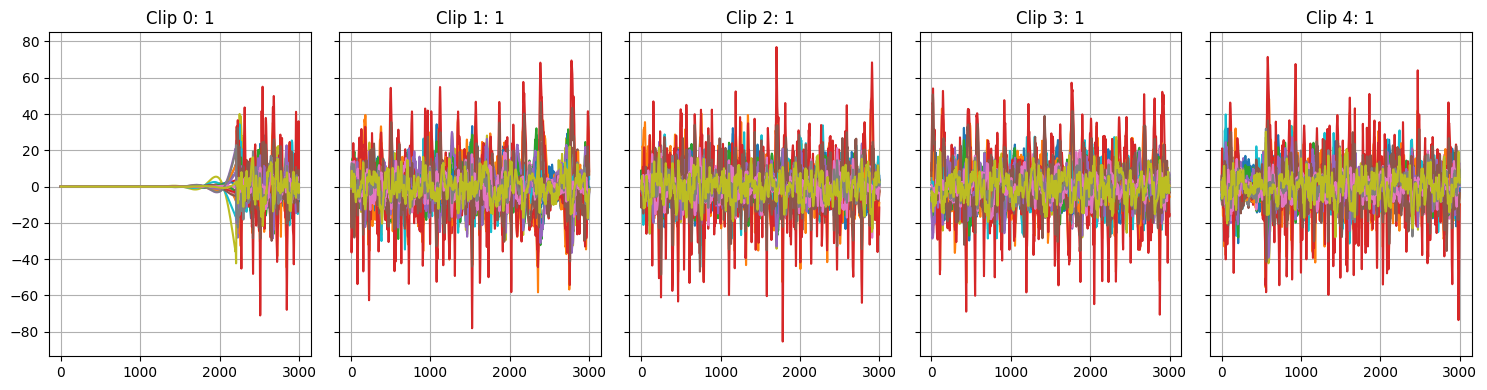

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i, (x, y) in enumerate(dataset_tr):
    if i > 4:
        break
    axes[i].plot(x)
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {y}"))

fig.tight_layout()
plt.show()

## Create the predefined graph

In [8]:
distances_df = pd.read_csv(DATA_ROOT / "distances_3d.csv")
distances_df.head()

,from,to,distance
0,FP1,FP1,0.000000
1,FP1,FP2,0.618000
2,FP1,F3,0.618969
3,FP1,F4,1.030322
4,FP1,C3,1.250226


In [9]:
src, dst, weights = [], [], []

nodes_names = distances_df["from"].unique()
N = len(distances_df["from"].unique())

for i in range(N):
    for j in range(N):
        src.append(i)
        dst.append(j)

        if i != j:
            nodes_distance = distances_df[(distances_df["from"] == nodes_names[i]) & (distances_df["to"] == nodes_names[j])]["distance"]
            weights.append(nodes_distance.item())
        else:
            weights.append(1) # how much distance do we want for the self loop, do we use the original 0 or?

In [10]:
edge_index = torch.tensor([src, dst], dtype=torch.long)
edge_weight = torch.tensor(weights, dtype=torch.float32)

In [11]:
print(edge_index.shape, edge_weight.shape)

torch.Size([2, 361]) torch.Size([361])


In [12]:
# from torch_geometric.utils import add_self_loops

# # Add self-loops and give them a custom weight, say 1.0
# edge_index, edge_weight = add_self_loops(edge_index, edge_weight=edge_weight, fill_value=1.0)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

loader_tr = DataLoader(dataset_tr, batch_size=512, shuffle=True)

for x, y in loader_tr:
    print(x.shape)
    print(y.shape)
    break

# 354 is the number of timesteps (frequencies)

torch.Size([512, 3000, 19])
torch.Size([512])


In [16]:
from models import GraphStructureLearner, DTGCN

# The node features here are the values at each timestep (so the frequency at each timestep)

glearner = GraphStructureLearner(3000, 32, device="mps")

# we want x to be windows of size k
k = 59


# we have to iterate with windows of size k inside the glearner ( and the windows overlap, lets say the window is of size 59, so we advanace one step each time)

In [17]:
for x, y in loader_tr:
    print(x.shape)
    # print(x.transpose(-2, -1).reshape(-1, 19, k, 354//k).shape)
    x = x.transpose(-2, -1) # get shape [batch_size, number of nodes, time_steps]
    print(x.shape)
    result = glearner(x.float().to("mps"), edge_index.to("mps"), edge_weight.to("mps"))
    print(result.shape)
    break

torch.Size([512, 3000, 19])
torch.Size([512, 19, 3000])
torch.Size([512, 19, 19])


In [18]:
dtgcn = DTGCN(19, 3000, 3000, 200, 200, 100, 1, 4, 2, "mps")

In [19]:
for x, y in loader_tr:
    x = x.transpose(-2, -1) # get shape [batch_size, number of nodes, time_steps]
    print(x.shape)
    dtgcn(x.float().to("mps"), edge_index.to("mps"), edge_weight.to("mps"))
    break

torch.Size([512, 19, 3000])


RuntimeError: MPS backend out of memory (MPS allocated: 17.91 GB, other allocations: 171.88 MB, max allowed: 18.13 GB). Tried to allocate 92.41 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).